In [33]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import math
import random
import pickle

In [34]:
t = time.time()

# Load preprocessed data
train_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_data.bp')
train_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_labels.bp')
train_kernel = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_spm_dist_mat.bp')
train_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_fnames.bp')

test_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_data.bp')
test_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_labels.bp')
test_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_fnames.bp')

sys.stderr.write('Load time: %f seconds\n' % (time.time() - t)) # ~ 2s / 12k training data

Load time: 2.883776 seconds


In [35]:
print train_X.shape
print train_kernel.shape
print test_X.shape

(14348, 4200)
(14348, 14348)
(3592, 4200)


In [36]:
class Hypersphere_abstain:
    
    def __init__(self, center, radius, threshold, label, alpha, beta, D, err, weighted_err, unweighted_err,
                 label_confidences, label_distribution, center_index, neighbor_indices, d_var, max_q_var):
        
        self.center = center
        self.radius = radius
        self.thres = threshold
        self.label = label
        self.alpha = alpha
        self.beta = beta
        self.D = D 
        self.pseudo_err = err # PSEUDO error
        self.weighted_err = weighted_err
        self.unweighted_err = unweighted_err
        self.label_confidences = label_confidences
        self.label_distribution = label_distribution
        self.center_index = center_index
        self.neighbor_indices = neighbor_indices
        
        # Hack
        self.d_var = d_var
        self.max_q_var = max_q_var
        
class WeakLearner_generator:
    
    def __init__(self, init_radius, growth_radius, end_radius, abstain_thres, err_thres):
        
        self.init_radius = init_radius
        self.growth_radius = growth_radius
        self.end_radius = end_radius
        self.abstain_thres = abstain_thres
        self.err_thres = err_thres
        
    def generate_pseudo(self, train_X, train_y, train_kernel, D, Q, mask, n_class):
        
        n_samples = train_X.shape[0]
        D = D.reshape((n_samples, ))

        # Choose an exemplar
        exemplar_index = np.random.choice(range(n_samples), p=D.tolist())
        exemplar = train_X[exemplar_index]

        # Retrieve scores to exemplar and sort
        scores = train_kernel[exemplar_index]
        sorted_scores = np.sort(scores)[::-1]
        sorted_indices = np.argsort(scores)[::-1]
        sorted_y = train_y[sorted_indices].astype('int64')
        sorted_D = D[sorted_indices]
        sorted_Q = Q[sorted_indices]
        sorted_mask = mask[sorted_indices]
        
        # Calculate plurarity and percentage of initial sphere
        init_size = np.argmax(sorted_scores<self.init_radius)
        count = np.bincount(sorted_y[:init_size],
                            weights=sorted_D[:init_size],
                            minlength=n_class)
        unweighted_count = np.bincount(sorted_y[:init_size],
                                       minlength=n_class)
        y_of_interest = np.argmax(count)
        percentage = count[y_of_interest]*1.0 / np.sum(sorted_D[:init_size])

        # Abstain test (HACK to avoid zero threshold)
        if np.sum(sorted_scores)==0.0:
            return None, None
        
        # Calculate cumulative weight sums
        sorted_D_tile = np.tile(sorted_D.reshape((n_samples,1)), (1, n_class))
        label_D_cum = np.cumsum(sorted_D_tile*sorted_mask, axis=0)
        label_Dq_cum = np.cumsum(sorted_D_tile*~sorted_mask*sorted_Q, axis=0)

        # Hypothesis and pseudo loss
#         radii = range(self.init_radius, n_samples, self.growth_radius)
#         radii = [self.init_radius*10]
#         radii = [n_samples]
        radii = np.arange(self.end_radius, self.init_radius+self.growth_radius, self.growth_radius)[::-1]
        hypo = np.zeros((len(radii), n_class), dtype=bool)
        pseudo_loss = np.zeros((len(radii),1))
        
        # For each radius
        for c,r in enumerate(radii):
            
            i = np.argmax(sorted_scores<r)
#             print '(Radius, Samples): ', (r, i)
            
            # Calculate best hypotheses
            deriv = -1.0*label_D_cum[i-1]+label_Dq_cum[i-1]
            hypo[c] = deriv<0.0
            label_conf = np.tile(hypo[c], (n_samples, 1))
    
            # Calculate three terms in pseudo loss
            ones_term = np.ones((n_samples,)).astype('float')
            label_term = np.sum(sorted_mask*label_conf, axis=1).astype('float')
            nonlabel_sum = np.sum(~sorted_mask*sorted_Q*label_conf, axis=1).astype('float')
            
            # Calculate pseudo loss
            pseudo_loss[c] = 0.5 * np.sum(sorted_D * (ones_term - label_term + nonlabel_sum))
            
        # Calculate best radius
        best_idx = np.argmin(pseudo_loss)
        best_radius = np.argmax(sorted_scores<radii[best_idx])
        
        # Prediction by best radius hypothesis
        label_conf = hypo[best_idx]
        p_err = pseudo_loss[best_idx]
#         print 'BEST RADIUS: ', best_radius
        
        if random.random()<0.025:
            print 'BEST SIZE: ', best_radius
            print 'BEST_PLOSS: ', p_err
            print 'BEST_HYPO: ', label_conf.astype('int')

        # Calculate label distritbution
        label_distribution = np.bincount(sorted_y[:best_radius], minlength=n_class)
    
        # Error test
        if p_err>self.err_thres:
            return None, None
        
        # Calculate alpha
        epsilon = 1.0e-24
        alpha = math.log((1.0-p_err+epsilon)/(p_err+epsilon))
        beta = (p_err+epsilon)*1.0/(1.0-p_err-epsilon)

        # Return weakleaner
        err = 0.0
        w_err = 0.0
        threshold = sorted_scores[best_radius-1]
        
        d_var = np.var(D)
        max_q_var= np.max(np.var(sorted_Q, axis=1))
        
        h = Hypersphere_abstain(exemplar, best_radius, threshold, y_of_interest,
                                alpha, beta, D, p_err, w_err, err, label_conf, label_distribution,
                                exemplar_index, sorted_indices, d_var, max_q_var)
        
        return h, sorted_mask
    

In [37]:
# Adaboost.M2

class Adaboost_M2:
    
    def __init__(self, iterations, n_class, weaklearner):
        
        self.T = iterations
        self.H = []
        self.D = None
        self.Q = None
        self.label_mask = None
        self.n_class = n_class
        self.weaklearner = weaklearner
    
    def train(self, train_X, train_y, train_kernel):
        
        n_samples = train_X.shape[0]
        
        # Create column mask for weights
        rows = list(xrange(n_samples))
        cols = train_y.astype('int64').tolist()
        self.label_mask = np.zeros((n_samples, self.n_class), dtype=bool)
        self.label_mask[rows, cols] = True
        
        # Initialize weights
        self.D = np.ones((n_samples, 1)) * (1.0/n_samples)
        self.Q = np.zeros((n_samples, self.n_class))
        self.Q += ~self.label_mask*np.ones((n_samples, self.n_class))*(1.0/(self.n_class-1))
        
        for t in xrange(self.T):

            if t%100==0:
                print 't: ', t
            
            # Generate weaklearner
            h, h_neighbor_label_mask = \
                self.weaklearner.generate_pseudo(train_X, train_y, train_kernel, self.D, self.Q, self.label_mask, self.n_class)
            
            # Check abstained
            if not h:
                continue
                
            self.H.append(h)

            # Reweight
            base_term = h.beta*np.ones((n_samples, self.n_class))
            ones_term = np.ones((n_samples, self.n_class))
            label_term = np.sum(h_neighbor_label_mask*h.label_confidences, axis=1).reshape((n_samples, 1))
            label_term = np.tile(label_term, ((1, self.n_class)))
            nonlabel_term = ~h_neighbor_label_mask*h.label_confidences
            
            power_term = 0.5*(ones_term + label_term - nonlabel_term)
            
#             print 'neighbor_indices: ', h.neighbor_indices.shape, h.neighbor_indices
            neighbors_in_sphere = h.neighbor_indices[:h.radius]
            neighbors_out_sphere = h.neighbor_indices[h.radius:]
            self.Q[neighbors_in_sphere] = self.Q[neighbors_in_sphere] * \
                                            np.power(base_term[:h.radius], power_term[:h.radius])
            self.Q[neighbors_out_sphere] = self.Q[neighbors_out_sphere] * \
                                            np.power(base_term[h.radius:], 0.5*ones_term[h.radius:])
            
            # Normalize
            Q_sample_sum = np.sum(self.Q, axis=1).reshape((n_samples, 1))
            self.Q = self.Q / Q_sample_sum
            self.D = Q_sample_sum / np.sum(Q_sample_sum)
#             print 'h: ', h.label_confidences.astype('int')
#             print 'Q: ', self.Q[:10,:]
#             print 'Q_sum: ', Q_sample_sum[:20]
            
            
        print 'Q_sum: \n', Q_sample_sum[:20]
        print 'Num classifiers: ', len(self.H)

    def predict(self, train_X, train_y, train_kernel=None):

        no_kernel = train_kernel==None
        n_samples = train_X.shape[0]
        cumulative_prob = np.zeros((n_samples, self.n_class)).astype('float')
        staged_pred_y = np.zeros((len(self.H), n_samples)).astype('int64')
        print 'n: ', n_samples
        
        if no_kernel:
            
            def compute_intersection_kernel_oneJob(i):
                dist = np.minimum(self.H[i].center, test_X)
                dist = np.sum(dist, axis=1).reshape((1, n_samples))
                return dist
            
            score_kernel = np.concatenate([compute_intersection_kernel_oneJob(i) for i in xrange(len(self.H))], axis=0)
            print 'Test kernel shape: ', score_kernel.shape
            
        else:
            score_kernel = None

        for i in xrange(len(self.H)):
            
            clf = self.H[i]
            
            score = np.copy(score_kernel[i]) if no_kernel else np.copy(train_kernel[clf.center_index])
            score[score < clf.thres] = 0.0 #Abstain
            score[score >= clf.thres] = math.log(1.0/clf.beta)
            
            label_weights = clf.label_confidences
            cumulative_prob += np.multiply(score.reshape((n_samples,1)), label_weights.reshape((1,self.n_class)))
            
            if i%50==0:
                print i, clf.radius,
                print 'Threshold: ', clf.thres
                print 'Abstained: ', np.sum(score==0.0),
                print 'Score==0: ', np.sum(np.sum(np.multiply(score.reshape((n_samples,1)), label_weights.reshape((1,self.n_class))), axis=1)==0),
                print 'Beta: ', clf.beta,
                print 'Label: ', clf.label
                print 'Hypo: ', clf.label_confidences.astype('int')
                print 'Cumulative: \n', cumulative_prob[:5,:5]
                
            max_prob = np.max(cumulative_prob, axis=1)
            pred_y = np.argmax(cumulative_prob, axis=1)
            pred_y[max_prob==0.0] = 0
            staged_pred_y[i,:] = pred_y
        
        print 'Correct predictions: ', np.sum(train_y==staged_pred_y[-1])
        
        return staged_pred_y


In [77]:
t = time.time()

# Setup
weak = WeakLearner_generator(init_radius=0.5,
                             growth_radius=0.05,
                             end_radius=0.3,
                             abstain_thres=0.5,
                             err_thres=1.0)
ada = Adaboost_M2(iterations=2000, 
                  n_class=16, 
                  weaklearner=weak)

sys.stderr.write('Setup time: %f seconds\n' % (time.time() - t)) # ~ 2s / 12k training data

Setup time: 0.012863 seconds


In [78]:
# Train

t = time.time()
ada.train(train_X, train_y, train_kernel)
sys.stderr.write('Train time: %f seconds\n' % (time.time() - t)) # ~ 15s / 12k training data

t:  0
BEST SIZE:  1
BEST_PLOSS:  [ 0.51807807]
BEST_HYPO:  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
BEST SIZE:  361
BEST_PLOSS:  [ 0.4808267]
BEST_HYPO:  [0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0]
BEST SIZE:  497
BEST_PLOSS:  [ 0.47143417]
BEST_HYPO:  [1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0]
BEST SIZE:  29
BEST_PLOSS:  [ 0.47183449]
BEST_HYPO:  [1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0]
t:  100
BEST SIZE:  325
BEST_PLOSS:  [ 0.47394602]
BEST_HYPO:  [1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0]
BEST SIZE:  43
BEST_PLOSS:  [ 0.49440804]
BEST_HYPO:  [0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0]
t:  200
BEST SIZE:  1638
BEST_PLOSS:  [ 0.48074243]
BEST_HYPO:  [0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0]
BEST SIZE:  1
BEST_PLOSS:  [ 0.49148739]
BEST_HYPO:  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
t:  300
BEST SIZE:  902
BEST_PLOSS:  [ 0.48752197]
BEST_HYPO:  [1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0]
BEST SIZE:  1
BEST_PLOSS:  [ 0.49926533]
BEST_HYPO:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
BEST SIZE:  52
BEST_PLOSS:  [ 0.50040363]
BEST_HYPO:  [0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0]


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars
Train time: 116.815512 seconds


[[ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]
 [ 0.95538331]]
Num classifiers:  1940


In [79]:
# for i in xrange(16):
#     print i, np.sum(ada.D[train_y==i])
# print 'Total: ', np.sum(ada.D)
# print 'Max: ', np.max(ada.D)

Labels:  set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])


<Container object of 16 artists>

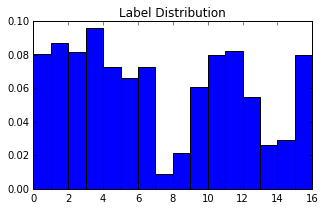

In [80]:
print 'Labels: ', set([h.label for h in ada.H])

label_distri = np.bincount([h.label for h in ada.H], minlength=16)
plt.figure(figsize=(5, 3))
plt.title('Label Distribution')
plt.bar(np.arange(0, 16), label_distri*1.0/np.sum(label_distri), width=1)

In [81]:
n_clf = len(ada.H)
beta_sum = np.zeros((16,1))
h_tp_sum = np.zeros((16,1))
h_sum = np.zeros((16,1))
for h in ada.H:
    beta_sum[h.label] += math.log(1.0/h.beta)
    h_tp_sum[h.label] += h.label_confidences[h.label]*1.0/n_clf #Correctly predicted
    h_sum += h.label_confidences.reshape((16,1))*1.0/n_clf
h_tp_sum = h_tp_sum/h_sum
for i,j,k,l in zip(xrange(16), beta_sum, h_tp_sum, h_sum) :
    print i,j,k,l

0 [ 11.03440511] [ 0.25762712] [ 0.30412371]
1 [ 6.78139356] [ 0.30943396] [ 0.27319588]
2 [ 14.82527159] [ 0.79396985] [ 0.10257732]
3 [ 6.05764567] [ 0.33333333] [ 0.27680412]
4 [ 2.38866751] [ 0.2339688] [ 0.29742268]
5 [ 5.00084952] [ 0.29767442] [ 0.22164948]
6 [ 4.27597829] [ 0.38082192] [ 0.18814433]
7 [-0.1696642] [ 0.69230769] [ 0.00670103]
8 [-1.78077711] [ 0.90697674] [ 0.02216495]
9 [ 5.02935225] [ 0.27400468] [ 0.22010309]
10 [ 7.68334988] [ 0.3974359] [ 0.20103093]
11 [ 4.58737899] [ 0.26279863] [ 0.30206186]
12 [ 3.41386287] [ 0.29787234] [ 0.16958763]
13 [-1.06506367] [ 0.3649635] [ 0.07061856]
14 [-2.3265881] [ 0.93442623] [ 0.0314433]
15 [ 14.30987617] [ 0.408] [ 0.19329897]


In [82]:
# Predict train

t = time.time()
staged_pred_y = ada.predict(train_X, train_y, train_kernel)
sys.stderr.write('Test time: %f seconds\n' % (time.time() - t)) # ~ 12s / 12k training data

n:  14348
0 3603 Threshold:  0.300010145148
Abstained:  10745 Score==0:  10745 Beta:  [ 0.81335625] Label:  5
Hypo:  [0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0]
Cumulative: 
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
50 79 Threshold:  0.35027173913
Abstained:  14269 Score==0:  14269 Beta:  [ 0.99904751] Label:  13
Hypo:  [0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0]
Cumulative: 
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.15092655  0.50009267  0.          0.50009267  0.50009267]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
100 1814 Threshold:  0.300008262414
Abstained:  12534 Score==0:  12534 Beta:  [ 0.89450538] Label:  12
Hypo:  [0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0]
Cumulative: 
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.  

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:73: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Test time: 5.396823 seconds


 3350


Label 0:  4072
Labels:  set([0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15])


<Container object of 16 artists>

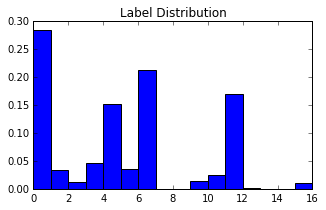

In [83]:
final_y = staged_pred_y[-1]
print 'Label 0: ', np.sum(final_y==0)
print 'Labels: ', set(final_y)

label_distri = np.bincount(final_y, minlength=16)
plt.figure(figsize=(5, 3))
plt.title('Label Distribution')
plt.bar(np.arange(0, 16), label_distri*1.0/np.sum(label_distri), width=1)
        

In [84]:
# Predict test

t = time.time()
staged_pred_y_test = ada.predict(test_X, test_y)
sys.stderr.write('Test time: %f seconds\n' % (time.time() - t)) # ~ 12s / 12k training data

n:  3592
Test kernel shape:  (1940, 3592)
0 3603 Threshold:  0.300010145148
Abstained:  2697 Score==0:  2697 Beta:  [ 0.81335625] Label:  5
Hypo:  [0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0]
Cumulative: 
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.20658607  0.          0.20658607  0.20658607]
 [ 0.          0.          0.          0.          0.        ]]
50 79 Threshold:  0.35027173913
Abstained:  3572 Score==0:  3572 Beta:  [ 0.99904751] Label:  13
Hypo:  [0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0]
Cumulative: 
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.81677472  1.02336079  0.          1.02336079  1.02336079]
 [ 0.7399938   0.46690011  0.          0.62812107  0.77192542]]
100 1814 Threshold:  0.

Test time: 172.584693 seconds


Label 0:  1077
Labels:  set([0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 15])


<Container object of 16 artists>

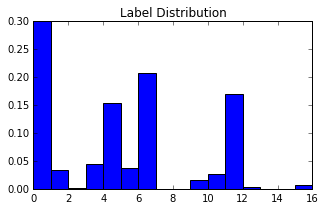

In [85]:
final_y = staged_pred_y_test[-1]
print 'Label 0: ', np.sum(final_y==0)
print 'Labels: ', set(final_y)

label_distri = np.bincount(final_y, minlength=16)
plt.figure(figsize=(5, 3))
plt.title('Label Distribution')
plt.bar(np.arange(0, 16), label_distri*1.0/np.sum(label_distri), width=1)

In [86]:
for h in ada.H[:10]:
    print train_kernel[h.center_index,h.neighbor_indices[:5]]

[ 1.          0.38300211  0.38265797  0.38246801  0.37601247]
[ 1.          0.36949891  0.32938676  0.32857143  0.3244278 ]
[ 1.          0.36924086  0.3620142   0.35878974  0.3493109 ]
[ 1.          0.47730824  0.34058941  0.33732535  0.33342617]
[ 1.          0.32532281  0.32287582  0.32269857  0.32140523]
[ 1.          0.31590414  0.31577373  0.31274986  0.30924979]
[ 1.          0.36806604  0.36015204  0.34872535  0.34199134]
[ 1.          0.37307999  0.3640522   0.36382647  0.36130645]
[ 1.          0.35615171  0.35249555  0.35017419  0.34816839]
[ 1.          0.37591975  0.37008241  0.37003765  0.35280211]


In [87]:

labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']


In [88]:
# Calculate true positive and abstain rate

# train_tp=[]
train_acc=[]
train_werr=[]
train_abstain_rate = []
n_training = staged_pred_y.shape[1]
for t, pred_y in enumerate(staged_pred_y):
    n_abstain = np.sum(pred_y==0)
#     n_tp_total = np.sum(pred_y!=0) if np.sum(pred_y!=0) else 1.0
#     n_tp_correct = np.sum(np.logical_and(pred_y!=0,pred_y==train_y))
    n_correct = np.sum(pred_y==train_y)
#     train_tp.append(1.0 * n_tp_correct / n_tp_total)
    train_acc.append(1.0 * n_correct / n_training)
    train_abstain_rate.append(1.0 * n_abstain / n_training)
    train_werr.append(np.sum((pred_y!=train_y)*ada.H[t].D))
    
# test_tp=[]
test_acc=[]
test_abstain_rate = []
n_testing = staged_pred_y_test.shape[1]
for pred_y in staged_pred_y_test:
    n_abstain = np.sum(pred_y==0)
#     n_tp_total = np.sum(pred_y!=0) if np.sum(pred_y!=0) else 1.0
#     n_tp_correct = np.sum(np.logical_and(pred_y!=0,pred_y==test_y))
    n_correct = np.sum(pred_y==test_y)
#     test_tp.append(1.0 * n_tp_correct / n_tp_total)
    test_acc.append(1.0 * n_correct / n_testing)
    test_abstain_rate.append(1.0 * n_abstain / n_testing)
    
print 'Training: ', n_training
print 'Final Accuracy: ', train_acc[-1]
print 'Testing: ', n_testing
print 'Final Accuracy: ', test_acc[-1]

Training:  14348
Final Accuracy:  0.2334820184
Testing:  3592
Final Accuracy:  0.202115812918


In [89]:
n_class = len(labels)
n_clf = len(ada.H)

# Pseudo loss
p_loss = []
d_var = []
q_var = []
for h in ada.H:
    p_loss.append(h.pseudo_err)
    d_var.append(h.d_var)
    q_var.append(h.max_q_var)

# Pseudo loss bound
p_loss_bound = np.array(p_loss)
p_loss_bound = np.power(p_loss_bound * (np.ones(p_loss_bound.shape)-p_loss_bound), 0.5)
p_loss_bound = np.cumprod(p_loss_bound)
p_loss_bound = (n_class-1) * np.power(2*np.ones(p_loss_bound.shape),np.array(xrange(1,n_clf+1))) * p_loss_bound

print [p[0] for p in p_loss[-10:]]
print p_loss_bound[-10:]
print train_werr[-10:]

[0.49218928064409118, 0.49853685920574181, 0.49853699832772569, 0.47549444085974829, 0.49511348694844726, 0.47942977314256574, 0.49093729778585288, 0.47942871507831952, 0.50277227074130149, 0.47719451277047237]
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
[0.76700598864372538, 0.76700668313401899, 0.7670058070245368, 0.76651793405542623, 0.7666493663038203, 0.76644812716314081, 0.76645043974003579, 0.76637896566288155, 0.76652013616950343, 0.76651708542219255]


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in power
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in multiply
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply


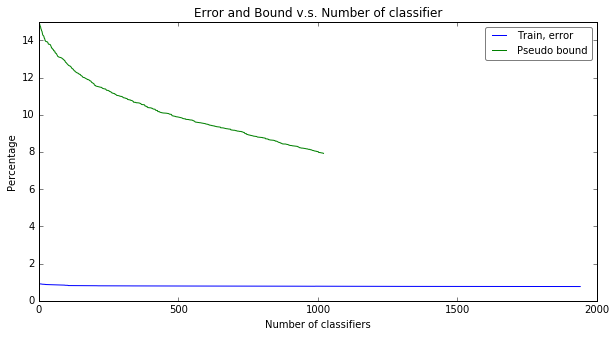

In [90]:
plt.figure(figsize=(10,5));

plt.title("Error and Bound v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage");
plt.ylim([0.0, 15.0]);
plt.plot(range(1, n_clf + 1), train_werr, label='Train, error');
plt.plot(range(1, n_clf + 1), p_loss_bound, label='Pseudo bound');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);

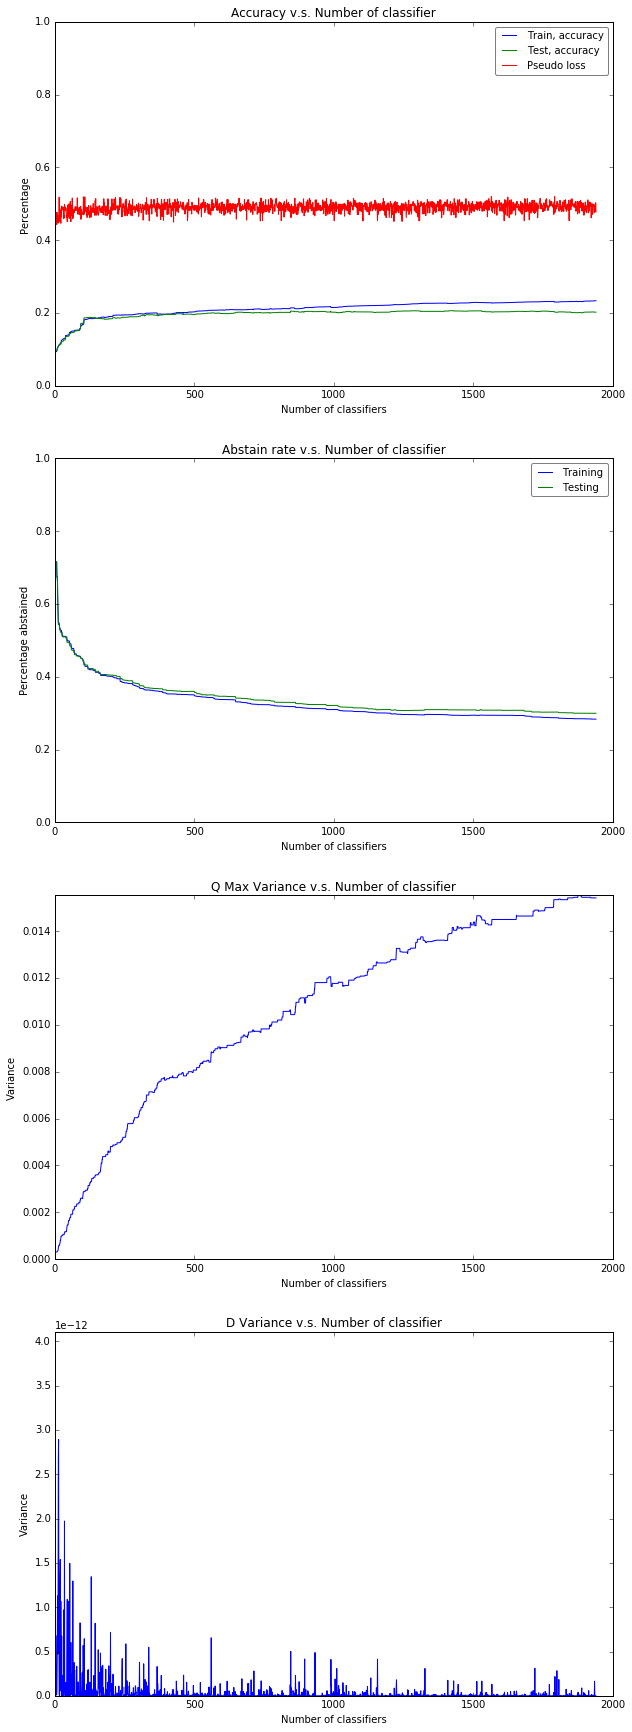

In [91]:
# Plot true positive and abstain rate

n_clf = len(ada.H);
plt.figure(figsize=(10,30));
plt.subplot(411);
plt.title("Accuracy v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage");
plt.ylim([0.0, 1.0]);
# plt.plot(range(1, n_clf + 1), train_tp, label='Train, true positive');
plt.plot(range(1, n_clf + 1), train_acc, label='Train, accuracy');
# plt.plot(range(1, n_clf + 1), test_tp, label='Test, true positive');
plt.plot(range(1, n_clf + 1), test_acc, label='Test, accuracy');
plt.plot(range(1, n_clf + 1), p_loss, label='Pseudo loss');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.60, 0, n_clf, linestyles=':', color='grey');
# plt.hlines(0.25, 0, n_clf, linestyles=':', color='grey');

plt.subplot(412);
plt.title("Abstain rate v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage abstained");
plt.ylim([0.0, 1.0]);
plt.plot(range(1, n_clf + 1), train_abstain_rate, label='Training');
plt.plot(range(1, n_clf + 1), test_abstain_rate, label='Testing');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.58, 0, n_clf, linestyles=':', color='grey');

plt.subplot(413);
plt.title("Q Max Variance v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Variance");
plt.ylim([0.0, max(q_var)]);
plt.plot(range(1, n_clf + 1), q_var, label='Q');
# plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.58, 0, n_clf, linestyles=':', color='grey');

plt.subplot(414);
plt.title("D Variance v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Variance");
plt.ylim([0.0, max(d_var)]);
plt.plot(range(1, n_clf + 1), d_var, label='D');
# plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.58, 0, n_clf, linestyles=':', color='grey');

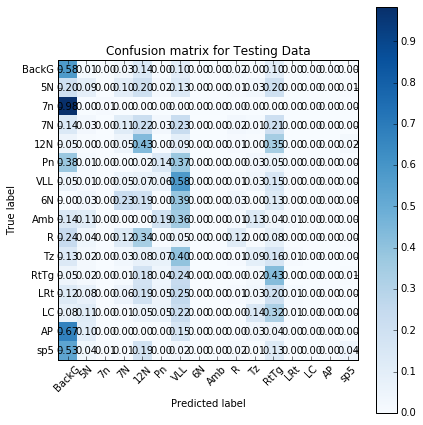

In [92]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if cm.dtype.type is np.int_:
        fmt = '%d'
    else:
        fmt = '%.2f'
    
    for x in xrange(len(labels)):
        for y in xrange(len(labels)):
            if not np.isnan(cm[y,x]):
                plt.text(
                    x,y,
                   fmt % cm[y,x],  
                   horizontalalignment='center',
                   verticalalignment='center');

cm_test = confusion_matrix(test_y, staged_pred_y_test[-1]);
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis];
plot_confusion_matrix(cm_test, labels, 'Confusion matrix for Testing Data');

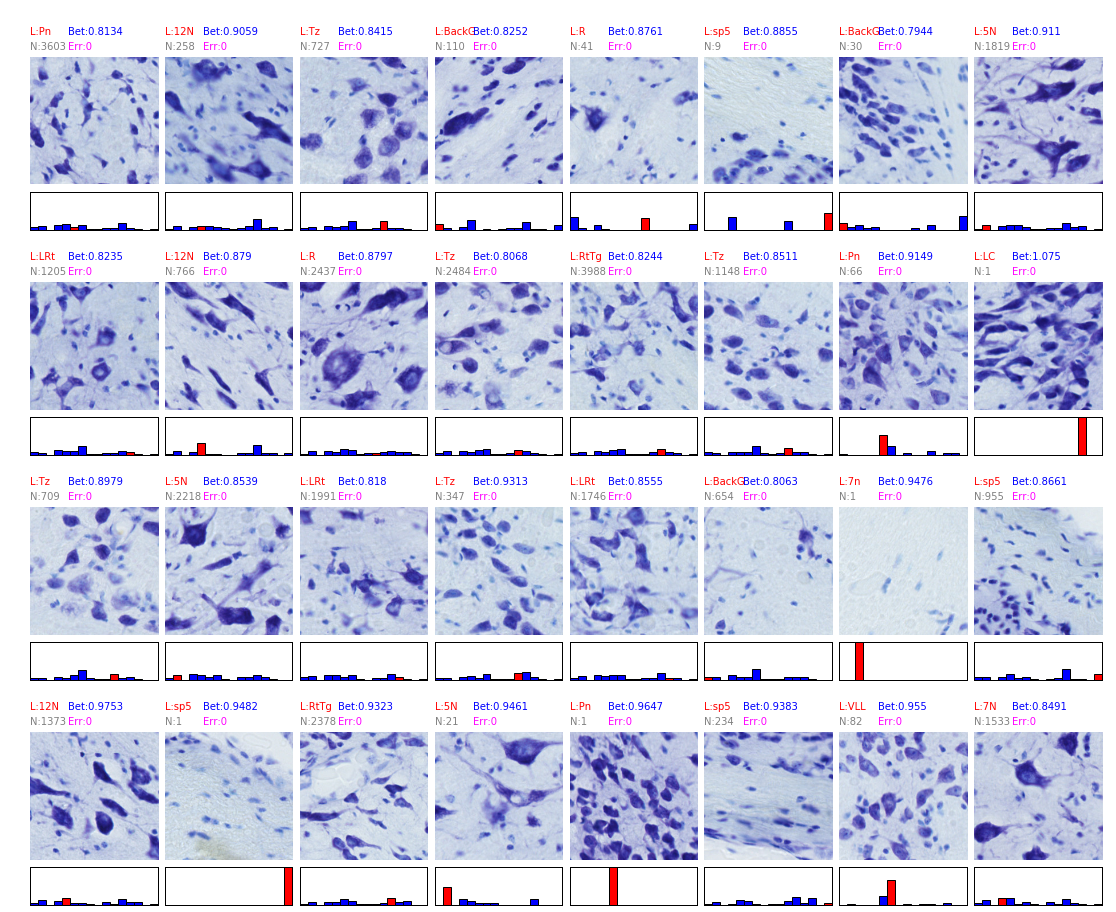

In [93]:
# Example hyperspheres

# for i in xrange(16):
#     print ada.H[i].label_distribution

subplot_width = 2.4
subplot_height = 4
fig_row = 4
fig_col = 8
plt.figure(figsize=(subplot_width * fig_col, subplot_height * fig_row))
plt.title('Information of hypersphere: (label, alpha, radius, number of examples)')
for row in range(0, fig_row):
    for col in range(0, fig_col):
        i = row * fig_col + col
        ax0 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row, 3 * col), colspan=3)
        ax0.text(0.0, 0.4, 'L:{}'.format(labels[ada.H[i].label]), fontsize=10, color='red')
        ax0.text(0.0, 0.0, 'N:{}'.format(ada.H[i].radius), fontsize=10, color='grey')
#         print ada.H[i].beta, float(ada.H[i].beta), ada.H[i].unweighted_err, float(ada.H[i].unweighted_err)
        ax0.text(0.3, 0.4, 'Bet:{:.4g}'.format(float(ada.H[i].beta)), fontsize=10, color='blue')
        ax0.text(0.3, 0.0, 'Err:{:.4g}'.format(float(ada.H[i].unweighted_err)), fontsize=10, color='magenta')
#         ax0.text(0.3, 0.0, 'Err:{:.2f}({:.2f})'.format(ada.H[i].unweighted_err, ada.H[i].weighted_err), fontsize=10, color='magenta');
#         ax0.text(0.6, 0.4, 'Uw.A:{:.2f}'.format(ada.H[i].unweighted_acc), fontsize=10, color='magenta');
        ax0.axison=False
        
        img=imread(train_fnames[ada.H[i].center_index])
        ax1 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row + 1, 3 * col), rowspan=3, colspan=3)
        ax1.imshow(img, cmap=plt.cm.gray)
        ax1.axis('off')
        
        ax2 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row + 4, 3 * col), colspan=3)
        ax2bar = ax2.bar(np.arange(0, 16), ada.H[i].label_distribution*1.0/sum(ada.H[i].label_distribution), width=1)
        ax2bar[ada.H[i].label].set_color('red')
        ax2bar[ada.H[i].label].set_edgecolor('black')
        ax2.axes.get_yaxis().set_visible(False)
        ax2.axes.get_xaxis().set_visible(False)
        ax2.axes.set_ylim([0.0, 1.0]) #HACK

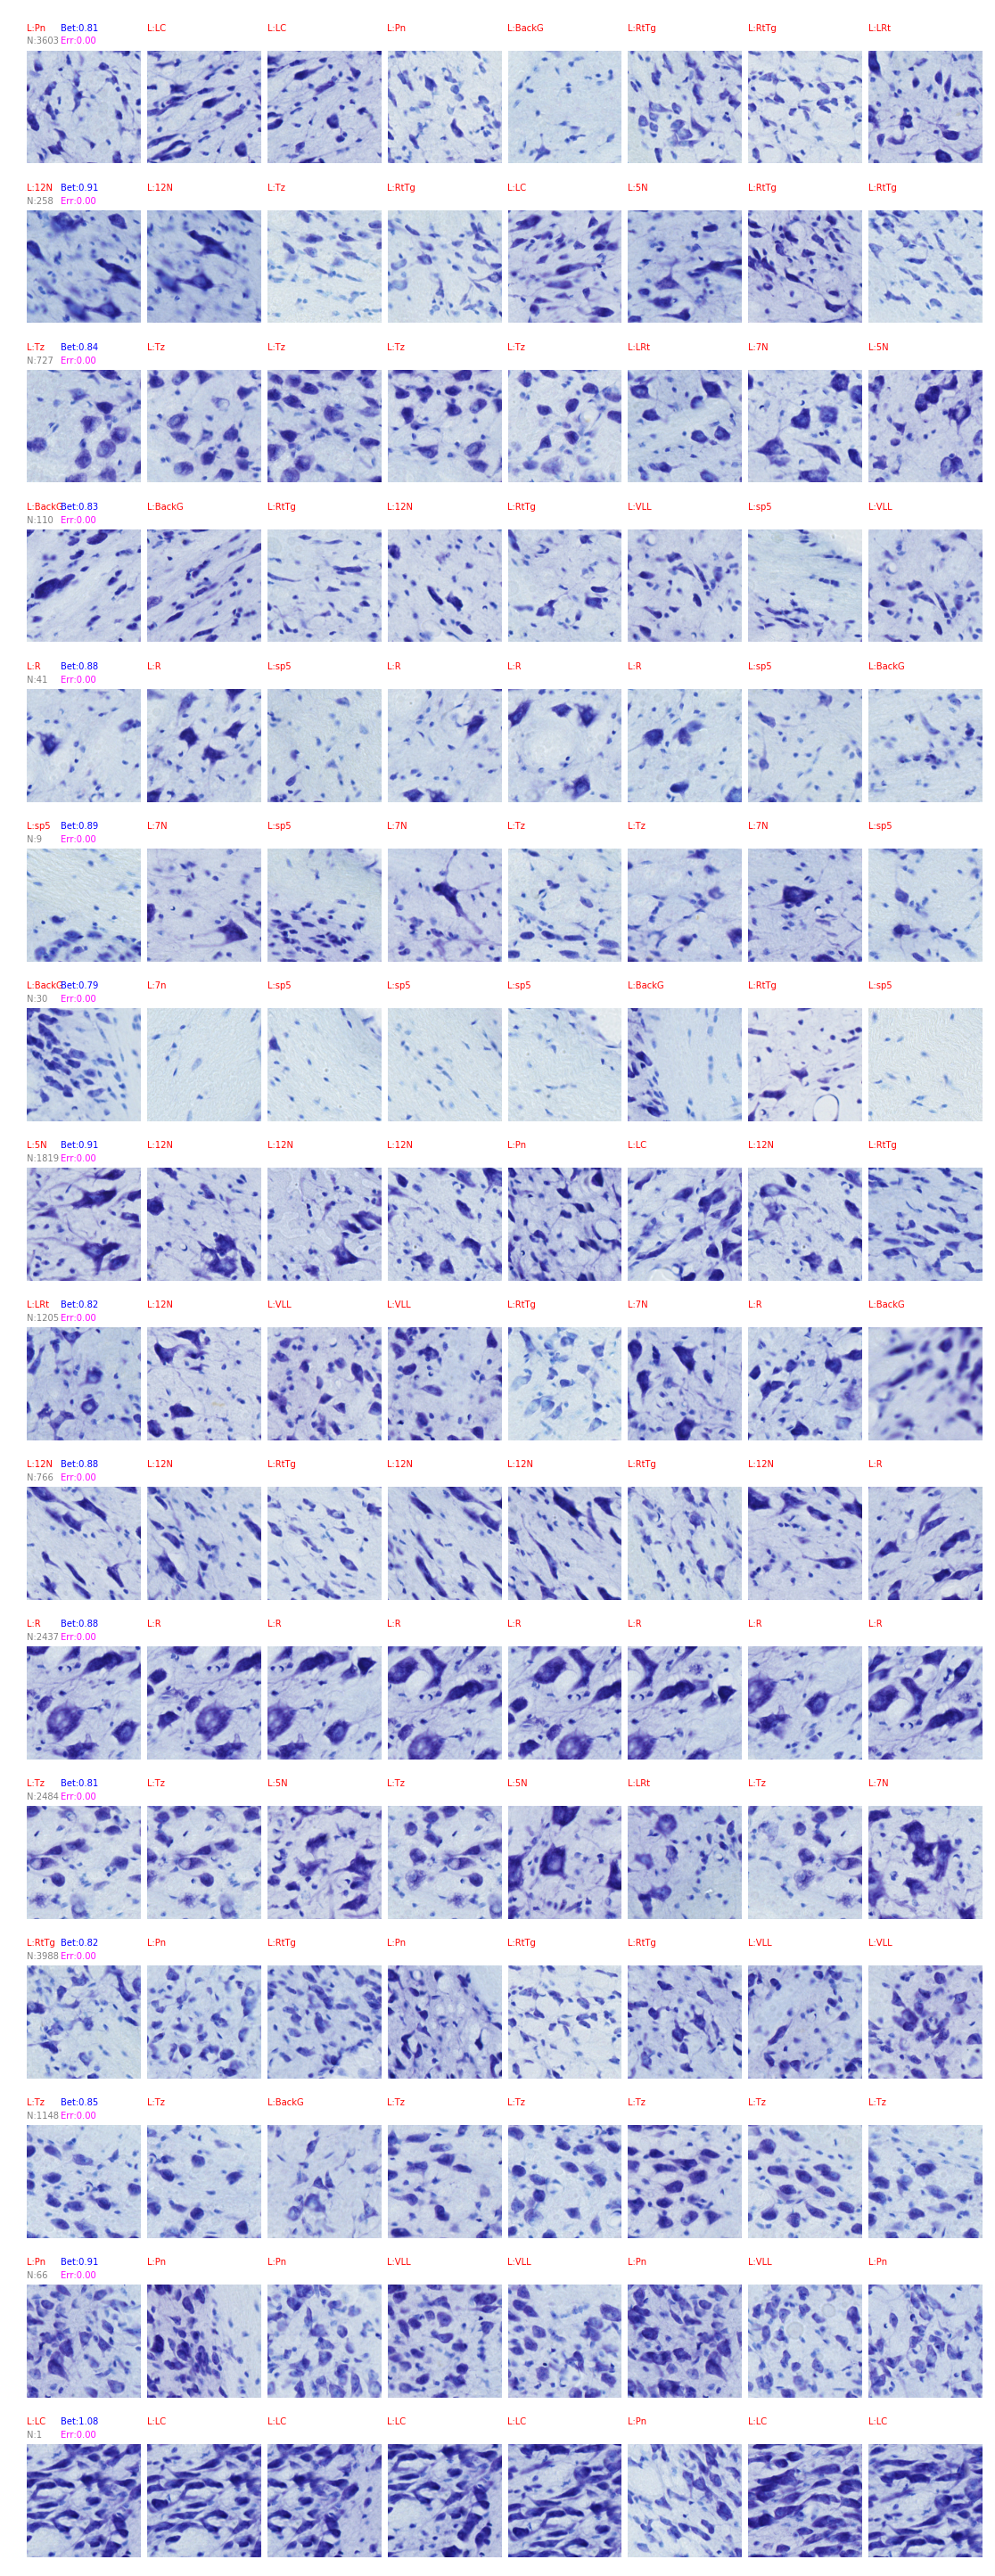

In [94]:
# Example hypersphere centers and their closest neighbors

subplot_width = 2.4;
subplot_height = 3.2;
fig_row = 16;
fig_col = 8;
plt.figure(figsize=(subplot_width * fig_col, subplot_height * fig_row));
for h in xrange(fig_row):
    for n in xrange(fig_col):
        ax0 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h, 3 * n), colspan=3);
        
        if n==0:
            ax0.text(0.0, 0.4, 'L:{}'.format(labels[ada.H[h].label]), fontsize=10, color='red');
            ax0.text(0.0, 0.0, 'N:{}'.format(ada.H[h].radius), fontsize=10, color='grey');
            ax0.text(0.3, 0.4, 'Bet:{:.2f}'.format(float(ada.H[h].beta)), fontsize=10, color='blue');
            ax0.text(0.3, 0.0, 'Err:{:.2f}'.format(float(ada.H[h].unweighted_err)), fontsize=10, color='magenta');
#             ax0.text(0.3, 0.0, 'Err:{:.2f}({:.2f})'.format(ada.H[h].unweighted_err, ada.H[h].weighted_err), fontsize=10, color='magenta');
#             ax0.text(0.3, 0.4, 'A:{:.2f}'.format(ada.H[h].alpha), fontsize=10, color='blue');
#             ax0.text(0.6, 0.4, 'Uw.A:{:.2f}'.format(ada.H[h].unweighted_acc), fontsize=10, color='magenta');
        else:
            ax0.text(0.0, 0.4, 'L:{}'.format(labels[int(train_y[ada.H[h].neighbor_indices[n]])]), fontsize=10, color='red');
        ax0.axison=False;
        
        img=imread(train_fnames[ada.H[h].neighbor_indices[n]]);
        ax1 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h + 1, 3 * n), rowspan=3, colspan=3);
        ax1.imshow(img, cmap=plt.cm.gray);
        ax1.axis('off');

In [95]:
# # Example hypersphere centers and their closest neighbors

# h_count = 0
# subplot_width = 2.4;
# subplot_height = 3.2;
# fig_row = 16;
# fig_col = 8;
# plt.figure(figsize=(subplot_width * fig_col, subplot_height * fig_row));

# for h in xrange(fig_row):
#     for n in xrange(fig_col):
#         ax0 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h, 3 * n), colspan=3);
        
#         while ada.H[h_count].label!=11:
#             h_count += 1
        
#         print 'h_count: ', h_count
#         print 'D(center): ', ada.H[h_count].D[ada.H[h_count].center_index]
#         print 'D_max: ', np.max(ada.H[h_count].D)
#         print 'D_min: ', np.min(ada.H[h_count].D)
        
#         if n==0:
# #             print ada.H[h_count].beta
#             ax0.text(0.0, 0.4, 'L:{}'.format(labels[ada.H[h_count].label]), fontsize=10, color='red');
#             ax0.text(0.0, 0.0, 'N:{}'.format(ada.H[h_count].radius), fontsize=10, color='grey');
#             ax0.text(0.3, 0.4, 'Bet:{:.2f}'.format(float(ada.H[h_count].beta)), fontsize=10, color='blue');
#             ax0.text(0.3, 0.0, 'Err:{:.2f}'.format(float(ada.H[h_count].unweighted_err)), fontsize=10, color='magenta');
# #             ax0.text(0.3, 0.0, 'Err:{:.2f}({:.2f})'.format(ada.H[h].unweighted_err, ada.H[h].weighted_err), fontsize=10, color='magenta');
# #             ax0.text(0.3, 0.4, 'A:{:.2f}'.format(ada.H[h].alpha), fontsize=10, color='blue');
# #             ax0.text(0.6, 0.4, 'Uw.A:{:.2f}'.format(ada.H[h].unweighted_acc), fontsize=10, color='magenta');
#         else:
#             ax0.text(0.0, 0.4, 'L:{}'.format(labels[int(train_y[ada.H[h_count].neighbor_indices[n]])]), fontsize=10, color='red');
#         ax0.axison=False;
        
#         img=imread(train_fnames[ada.H[h_count].neighbor_indices[n]]);
#         ax1 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h + 1, 3 * n), rowspan=3, colspan=3);
#         ax1.imshow(img, cmap=plt.cm.gray);
#         ax1.axis('off');
        
#         h_count += 1